In [1]:
#Import Packages
from sklearn.datasets import load_files
from glob import glob
#from scipy.misc import imread
from sklearn.model_selection import train_test_split

import numpy as np
import random
import time
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
FIXED_IMG_SIZE = 227

#Load the full dataset, scale the images in values between 0-1 and resize to size 227
def load_dataset(path, target):
    filenames = glob(path)
    
    if target == 0:
        cls = [1,0] #female - 0
    else:
        cls = [0,1] #male - 1
        
    target_array = np.full(shape=(len(filenames),2), fill_value=cls, dtype='float32')
    #target_array = np.ndarray((len(filenames),1), target)
    
    images = [cv2.imread(file) for file in filenames]
    images = [cv2.resize(img, (FIXED_IMG_SIZE, FIXED_IMG_SIZE)) for img in images]
    
    images = np.array(images, dtype = np.uint8)
    images = images.astype('float32')
    images = np.multiply(images, 1.0/255.0)
    
    train_x, test_x, train_y, test_y = train_test_split(images, target_array, test_size=0.4) #solve problem
    valid_x, test_x, valid_y, test_y = train_test_split(test_x, test_y, test_size=0.5)
        
    return train_x, valid_x, test_x, train_y, valid_y, test_y

In [3]:
print('Loading Datasets')
fem_train_x, fem_valid_x, fem_test_x, fem_train_y, fem_valid_y, fem_test_y = female_test = load_dataset('data/female/*', target=1)
print('Loaded Female Dataset')

male_train_x, male_valid_x, male_test_x, male_train_y, male_valid_y, male_test_y = load_dataset('data/male/*', target=0)
print('Loaded Male Dataset')

train_len = len(fem_train_x) + len(male_train_x)
valid_len = len(fem_valid_x) + len(male_valid_x)
test_len = len(fem_test_x) + len(male_test_x)

print('Both datasets loaded')
print('Number of Training Data: ' + str(train_len))
print('Number of Validation Data: ' + str(valid_len))
print('Number of Testing Data: ' + str(test_len))

Loading Datasets
Loaded Female Dataset
Loaded Male Dataset
Both datasets loaded
Number of Training Data: 7936
Number of Validation Data: 2646
Number of Testing Data: 2647


In [40]:
#Inputs
train_x = np.concatenate((fem_train_x, male_train_x), axis=0)
valid_x = np.concatenate((fem_valid_x, male_valid_x), axis=0)
test_x = np.concatenate((fem_test_x, male_test_x), axis=0)

#targets 
train_y = np.concatenate((fem_train_y, male_train_y), axis=0)
valid_y = np.concatenate((fem_valid_y, male_valid_y), axis=0)
test_y = np.concatenate((fem_test_y, male_test_y), axis=0)

In [43]:
import tensorflow as tf
def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.01), name='create_w8')

def create_biases(num_filters):
    return tf.Variable(tf.zeros(num_filters), name='create_biases') #CHECK WITH NON-ZERO VALUE                       

In [44]:
def create_conv_layer(input, num_input_channels, filter_size, num_filters, conv_strides=1, conv_padding='SAME'):
    #define weights and biases
    weights = create_weights(shape=[filter_size, filter_size, num_input_channels, num_filters])
    biases = create_biases(num_filters=num_filters)
    
    #define conv2d layer
    conv_layer = tf.nn.conv2d(input=input, filter=weights, strides=[1,conv_strides,conv_strides,1], padding=conv_padding)
    conv_layer += biases
    
    #max pooling layer
    conv_layer = tf.nn.max_pool(value=conv_layer, ksize=[1,2,2,1], padding='SAME', strides=[1,2,2,1])
    
    #relu layer
    conv_layer = tf.nn.relu(conv_layer)
    
    #local response normalization layer
    conv_layer = tf.nn.local_response_normalization(conv_layer)
    
    return conv_layer

In [45]:
#flatten layer
def create_flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_elements = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_elements])
    
    return layer

In [46]:
#create fully connected layers
def create_fully_conn_layer(input, num_inputs, num_outputs, use_relu=True, use_dropout=True):
    #define weights and biases for fully connected layer
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    
    fconn_layer = tf.matmul(input, weights) + biases
    if use_relu:
        fconn_layer = tf.nn.relu(fconn_layer)
        
    if use_dropout:
        fconn_layer = tf.nn.dropout(fconn_layer, keep_prob=0.2)
        
    return fconn_layer

In [47]:
# def next_batch(batch_size, data, labels): 
    
#     num_batches = data.shape[0] // batch_size
#     print(data.shape[0])
    
#     data = data[:num_batches*batch_size]
#     labels = labels[:num_batches*batch_size]
    
#     count = 1
#     for i in range(0, data.shape[0], batch_size):
        
#         if count > num_batches:
#             count += 1
#             i = 0
        
#         x = data[i : i + batch_size ,:]
#         y = np.squeeze(labels[i : i + batch_size ,:], axis=1)
        
#         count += 1
#         yield x, y

In [48]:
def shuffle_dataset_batch(batch_size, data, labels):
    idx = np.arange(0, len(data))
    random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    label_shuffle = [labels[i] for i in idx]
    
    return np.asarray(data_shuffle), np.asarray(label_shuffle)

In [49]:
#Global Variables
batch_size = 32
num_epochs = 2
learning_rate=0.05

#define placeholders and input
num_channels = 3
num_classes = 2
x = tf.placeholder(dtype=tf.float32, shape=[None, FIXED_IMG_SIZE, FIXED_IMG_SIZE, num_channels], name='x') 
y_true = tf.placeholder(dtype=tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [50]:
#Define Network Architecture

layer_conv1 = create_conv_layer(input=x, num_filters = 96, filter_size=7, conv_strides=4, conv_padding='VALID', num_input_channels=num_channels)
print(layer_conv1.get_shape())

layer_conv2 = create_conv_layer(input=layer_conv1, num_filters = 256, filter_size=5, conv_strides=1, 
                                conv_padding='SAME', num_input_channels=96)
print(layer_conv2.get_shape())

layer_conv3 = create_conv_layer(input=layer_conv2, num_filters = 256, filter_size=3, conv_strides=1, 
                                conv_padding='SAME', num_input_channels=256)
print(layer_conv3.get_shape())

layer_flat = create_flatten_layer(layer=layer_conv3)
print(layer_flat.get_shape())

layer_fc1 = create_fully_conn_layer(input=layer_flat, num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                                   num_outputs=512)
print(layer_fc1.get_shape())

layer_fc2 = create_fully_conn_layer(input=layer_fc1, num_inputs=512, num_outputs=512)
print(layer_fc2.get_shape())

layer_fc3 = create_fully_conn_layer(input=layer_fc2, num_inputs=512, num_outputs=num_classes, 
                                    use_relu=False, use_dropout=False)
print(layer_fc3.get_shape())

#softmax layer
y_pred = tf.nn.softmax(layer_fc3, name='y_pred')
y_pred_cls = tf.argmax(y_pred, axis=1)

# #define cost
loss = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3, labels=y_true)
cost = tf.reduce_mean(loss)
accuracy = tf.multiply(tf.reduce_mean(tf.cast(tf.equal(y_pred_cls, y_true_cls), tf.float32)), 100)

#adam optimisation
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) #learning rate variable

(?, 28, 28, 96)
(?, 14, 14, 256)
(?, 7, 7, 256)
(?, 12544)
(?, 512)
(?, 512)
(?, 2)


In [15]:
#Run Tensorflow session
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #sess.run(tf.initialize_all_variables()()

    epoch_data = []
    train_loss_list, valid_loss_list = [], []
    for e in range(1, num_epochs):

        start_time = time.time()
        
        num_batches = train_len // batch_size
        if num_batches > 10: #limit the number of batches for faster calculations
            num_batches = 10
        
        print('Epoch {}/{} :-------'.format(e, num_epochs))
        for batch in range(0, num_batches):
            
            x_train_batch, y_train_batch = shuffle_dataset_batch(batch_size, data=train_x, labels=train_y)
            x_valid_batch, y_valid_batch = shuffle_dataset_batch(batch_size, data=valid_x, labels=valid_y)

            feed_dict_train = {x : x_train_batch, y_true : y_train_batch}
            feed_dict_valid = {x : x_valid_batch, y_true : y_valid_batch}
            sess.run(optimizer, feed_dict=feed_dict_train)
            
            train_loss = sess.run(cost, feed_dict=feed_dict_train)
            valid_loss = sess.run(cost, feed_dict=feed_dict_valid)

            #print('Batch {}/{} :-------'.format(batch, num_batches))
  
        train_accuracy = sess.run(accuracy, feed_dict=feed_dict_train)
        valid_accuracy = sess.run(accuracy, feed_dict=feed_dict_valid)

        valid_pred = sess.run(y_pred, feed_dict=feed_dict_valid)
        valid_true_cls = sess.run(y_true_cls, feed_dict=feed_dict_valid)
        valid_predict_cls = sess.run(y_pred_cls, feed_dict=feed_dict_valid)
        
        end_time = time.time() 
        
        epoch_data.append((valid_pred, valid_predict_cls, valid_true_cls))
        
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        print('Epoch Time {} (s):----'.format(end_time - start_time),
              'Training Loss {} :-------'.format(train_loss),
              'Training Accuracy {}% :------'.format(train_accuracy),
              'Validation Loss {} :-------'.format(valid_loss),
              'Validation Accuracy {}% :'.format(valid_accuracy))
              #'Validation True Class / Pred Class {}/{} :--'.format(valid_true_cls, valid_predict_cls)))
    
    saved_path = saver.save(sess, 'saved_model/gender_class_model.ckpt')
    print('Model saved in path: {}'.format(saved_path))

Epoch 1/7 :-------
Epoch Time 39.0202362537384 (s):---- Training Loss 48.09536361694336 :------- Training Accuracy 78.125% :------ Validation Loss 38.54120635986328 :------- Validation Accuracy 62.5% :
Epoch 2/7 :-------
Epoch Time 38.81666326522827 (s):---- Training Loss 0.6697645783424377 :------- Training Accuracy 78.125% :------ Validation Loss 0.5232861638069153 :------- Validation Accuracy 71.875% :
Epoch 3/7 :-------
Epoch Time 38.80437469482422 (s):---- Training Loss 0.6942024230957031 :------- Training Accuracy 59.375% :------ Validation Loss 0.5662342309951782 :------- Validation Accuracy 65.625% :
Epoch 4/7 :-------
Epoch Time 38.83106184005737 (s):---- Training Loss 0.7120850682258606 :------- Training Accuracy 71.875% :------ Validation Loss 0.5279893279075623 :------- Validation Accuracy 81.25% :
Epoch 5/7 :-------
Epoch Time 38.82670474052429 (s):---- Training Loss 0.4774278998374939 :------- Training Accuracy 81.25% :------ Validation Loss 0.5893272161483765 :------- Va

In [52]:
#restore the model
with tf.Session() as sess:
    
    saver.restore(sess, 'saved_model/gender_class_model.ckpt')
    print('Model restored')
    print(epoch_data[num_epochs-2])
# #tf.get_variable

INFO:tensorflow:Restoring parameters from saved_model/gender_class_model.ckpt
Model restored
(array([[1.0000000e+00, 0.0000000e+00],
       [7.6002479e-01, 2.3997520e-01],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 6.5909612e-17],
       [7.9405969e-01, 2.0594026e-01],
       [9.7423911e-01, 2.5760900e-02],
       [1.0000000e+00, 7.0779368e-36],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.2002107e-26],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.9897240e-15],
       [9.9999273e-01, 7.3208025e-06],
       [1.0000000e+00, 4.6049892e-10],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [7.2279018e-01, 2.7720985e-01],
       [1.0000000e+00, 1.4849679e-08],
       [1.0000000e+00, 0.0000000e+00],
       [9

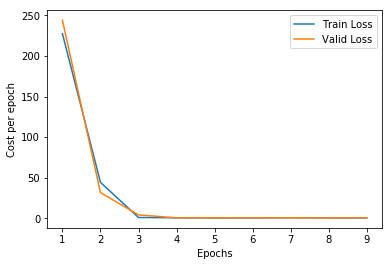

In [31]:
#Plot train and validation loss curve to understand the performance of the model
plt.plot(range(1,10), train_loss_list, label='Train Loss')
plt.plot(range(1,10), valid_loss_list, label='Valid Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cost per epoch')

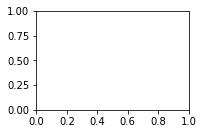

In [12]:
#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

In [13]:
#detect human face boundaries
# def face_detector(img_path):
#     img = cv2.imread(img_path)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     faces = face_cascade.detectMultiScale(gray)
    
#     return len(faces) > 0